## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [22]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
sys.path.append('..')
import mae.prod.models_mae
from src.Dataloader import CombineDataloader, TrainDataloader, TrainDataloader256


P = 0.75



# # check whether run in Colab
# if 'google.colab' in sys.modules:
#     print('Running in Colab.')
#     !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
#     !git clone https://github.com/facebookresearch/mae.git
#     sys.path.append('./mae')
# else:
#     sys.path.append('..')



### Define utils

In [23]:
P = 0.75

def show_image(image, title=''):
    # image is [H, W, 3]
    # assert image.shape[2] == 3
    x = np.empty((image.shape[0],image.shape[1],3))
    for i in range(3):
        x[:,:,i] = image

    image = x
    plt.imshow(image)
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='vit_for_FT'):
    # build model
    model = getattr(mae.prod.models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location=torch.device('cuda'))
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    model.cuda()
    return model


def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=P)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()
    print("loss", loss)

    # visualize the mask
    mask = mask.detach()
    # (N, H*W, p*p*3)
    mask = mask.unsqueeze(-1).repeat(1, 1,
                                     model.patch_embed.patch_size[0]**2 * 3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Load an image

In [24]:
import json
params = json.loads(open("params/params_2014.json").read())

dl = TrainDataloader256("train", params["dataset"])
dl.mean = 0
dl.std = 1

img, _, _ = dl[0]
# img = img.squeeze(0)
# img = resize(img,(224,224))
print(img.shape)

# assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
# img = img - imagenet_mean
# img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))


# This is an MAE model trained with pixels as targets for visualization
# (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
# !wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = '/home/initial/Dropbox/flare_transformer/mae/prod/output_dir/checkpoint-15.pth'
model_mae = prepare_model(chkpt_dir)
print('Model loaded.')

# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)


data/data_2010_label.csv
data/data_2011_label.csv
data/data_2012_label.csv
data/data_2013_label.csv
data/data_2010_feat.csv
data/data_2011_feat.csv
data/data_2012_feat.csv
data/data_2013_feat.csv
data/data_2010_window_48.csv
data/data_2011_window_48.csv
data/data_2012_window_48.csv
data/data_2013_window_48.csv
img: torch.Size([29247, 1, 256, 256]) label: (29247, 4) feat: (29247, 90) window: (29247, 4)
torch.Size([4, 1, 256, 256])


/tmp/ipykernel_29134/3328785358.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  show_image(torch.tensor(img))


ValueError: could not broadcast input array from shape (4,1,256,256) into shape (4,1)

### Load a pre-trained MAE model

In [ ]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
# !wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = '/home/initial/Dropbox/flare_transformer/output_dir/checkpoint-1.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')


<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss tensor(0.0030, grad_fn=<DivBackward0>)


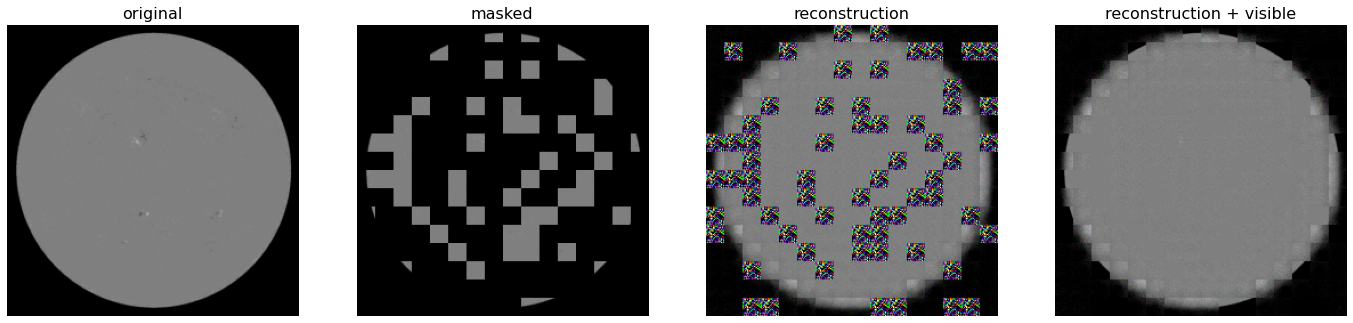

In [ ]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)

### Load another pre-trained MAE model

In [ ]:
# # This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# # download checkpoint if not exist
# !wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

# chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
# model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
# print('Model loaded.')

### Run MAE on the image

In [ ]:
# # make random mask reproduciberle (comment out to make it change)
# torch.manual_seed(2)
# print('MAE with extra GAN loss:')
# run_one_image(img, model_mae_gan)